#### Benchmaking Experiment 006b
- benchmarking model architecture -3 with PAMAP2, DaLiAc and UTD-MHAD datasets
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd
import json

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

import numpy.random as random
from src.datasets.data import PAMAP2ReaderV2
from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

# from src.running import train_step1, eval_step1

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "SOTAEmbedding",
    "model_params":{
        "linear_filters":[1024,1024,1024,512],
        "input_feat":36,
        "dropout":0.1,
    },
    "folding": True,
    "lr": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 64,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [3]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_Pse3D_512"
models_saves = "model_saves"

In [4]:
dataReader = PAMAP2ReaderV2('data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


D:\FYP\HAR-ZSL-XAI\src\datasets\data.py:525: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


[ 1  2  3  4  5  6  7  9 10 11 12 13 16 17 18 19 20 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Model Building

In [5]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=102, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [6]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [7]:
emb = model(torch.randn((32,36)))
emb.size()

torch.Size([32, 512])

In [8]:
emb

tensor([[0.0000, 0.0000, 1.2137,  ..., 1.5502, 1.1042, 2.1066],
        [0.3609, 0.7348, 0.0000,  ..., 1.3865, 0.0000, 0.3736],
        [0.6122, 0.0000, 0.0173,  ..., 0.0000, 0.1284, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2156,  ..., 0.5372, 1.3092, 0.6700],
        [0.0000, 0.0000, 0.8775,  ..., 0.4718, 2.2185, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0984, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

---

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

---

In [10]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
dataReader.data.shape

(124,)

In [12]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [13]:
dts = PAMAP2Dataset

In [14]:
import pickle

with open("E:\\FYP_Data\\Pose3D\\dropout_prototypes.pkl","rb") as f0:
    prototype_map = pickle.load(f0)

In [15]:
video_data = prototype_map
video_classes, video_feat = np.asarray(list(prototype_map.keys())), np.asarray(list(prototype_map.values()))

In [16]:
video_feat.shape,list(prototype_map.keys())

((18, 512),
 ['Nordic walking',
  'ascending stairs',
  'car driving',
  'computer work',
  'cycling',
  'descending stairs',
  'folding laundry',
  'house cleaning',
  'ironing',
  'lying',
  'playing soccer',
  'rope jumping',
  'running',
  'sitting',
  'standing',
  'vacuum cleaning',
  'walking',
  'watching TV'])

In [17]:
video_classes,len(np.unique(video_classes))

(array(['Nordic walking', 'ascending stairs', 'car driving',
        'computer work', 'cycling', 'descending stairs', 'folding laundry',
        'house cleaning', 'ironing', 'lying', 'playing soccer',
        'rope jumping', 'running', 'sitting', 'standing',
        'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'),
 18)

In [18]:
vid_cls_name = np.unique(video_classes)

In [19]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [20]:
selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

torch.Size([18, 512])

In [21]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [22]:
np.unique(video_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [23]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [24]:
action_dict

defaultdict(list,
            {6: [0],
             10: [1],
             9: [2],
             8: [3],
             5: [4],
             11: [5],
             14: [6],
             15: [7],
             13: [8],
             0: [9],
             16: [10],
             17: [11],
             4: [12],
             1: [13],
             2: [14],
             12: [15],
             3: [16],
             7: [17]})

In [25]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
data_dict['train']['X'].shape,data_dict['train']['y'].shape

((16752, 36), (16752,))

In [27]:
action_dict

defaultdict(list,
            {6: [0],
             10: [1],
             9: [2],
             8: [3],
             5: [4],
             11: [5],
             14: [6],
             15: [7],
             13: [8],
             0: [9],
             16: [10],
             17: [11],
             4: [12],
             1: [13],
             2: [14],
             12: [15],
             3: [16],
             7: [17]})

In [28]:
data_dict['seen_classes']

[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]

In [29]:
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(100*np.isinf(d[0].numpy()).sum()/(d[0].shape[0]*d[0].shape[1]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [30]:
sample_dt.action2Id

{0: 0,
 1: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 8: 6,
 9: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 16: 12,
 17: 13}

In [31]:
sample_dt.attribute_dict

defaultdict(list,
            {6: [0],
             10: [1],
             9: [2],
             8: [3],
             5: [4],
             11: [5],
             14: [6],
             15: [7],
             13: [8],
             0: [9],
             16: [10],
             17: [11],
             4: [12],
             1: [13],
             2: [14],
             12: [15],
             3: [16],
             7: [17]})

In [32]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 512])

In [33]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.cosine_similarity(entry.repeat(num_classes,1),selected_features)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [34]:
def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

In [35]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [36]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

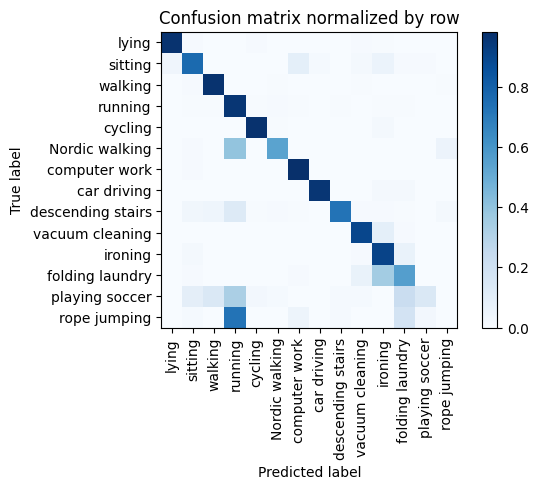

Overall accuracy: 0.840



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

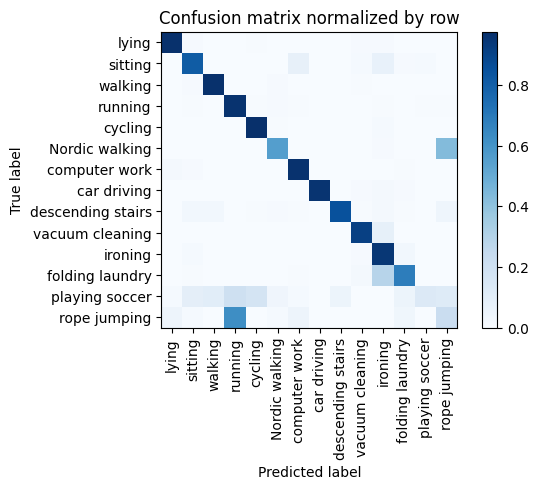

Overall accuracy: 0.865



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

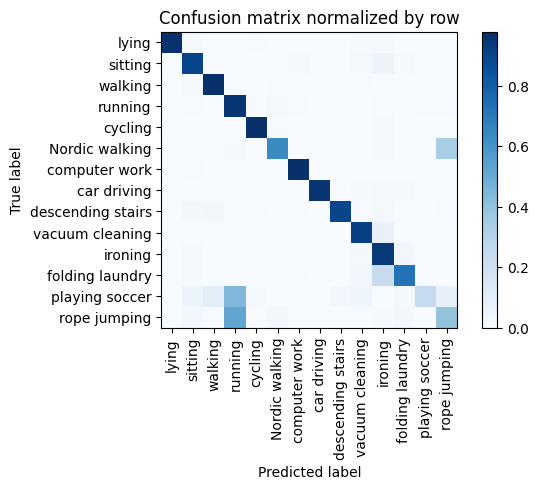

Overall accuracy: 0.891



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

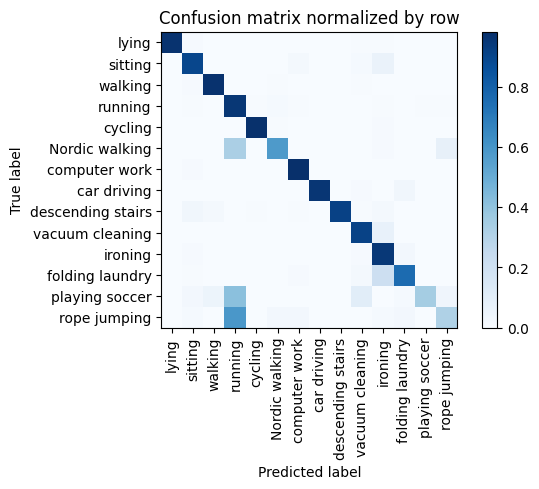

Overall accuracy: 0.890



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

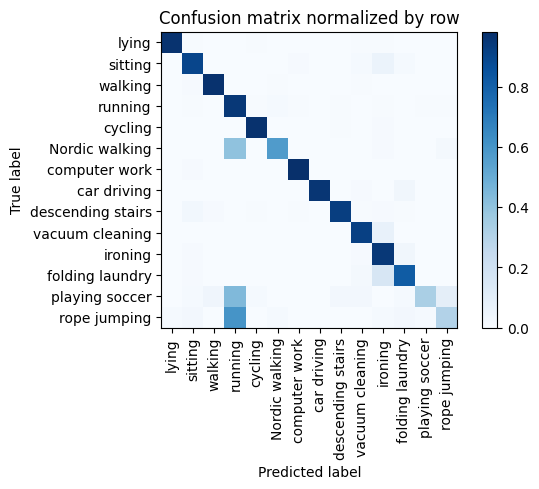

Overall accuracy: 0.892



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

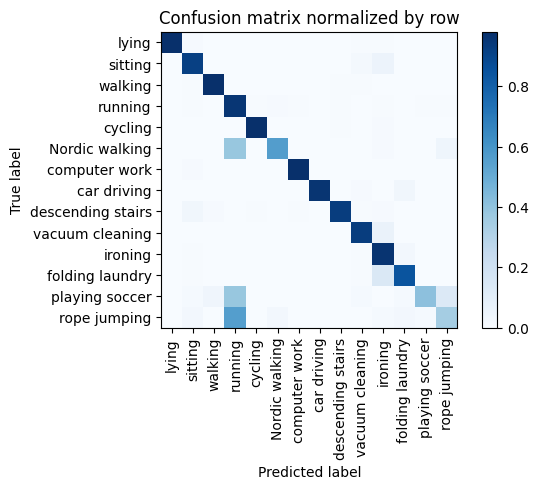

Overall accuracy: 0.900



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

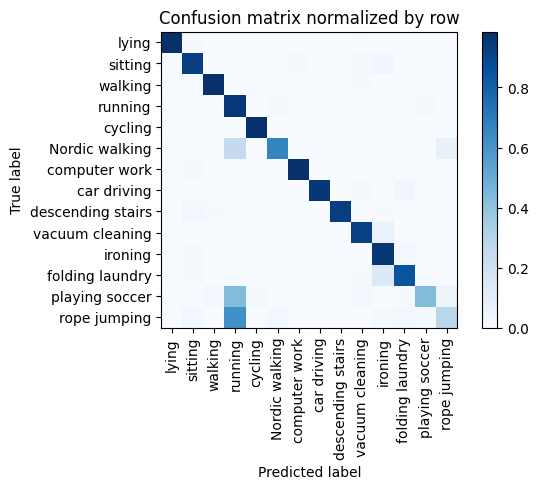

Overall accuracy: 0.908



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

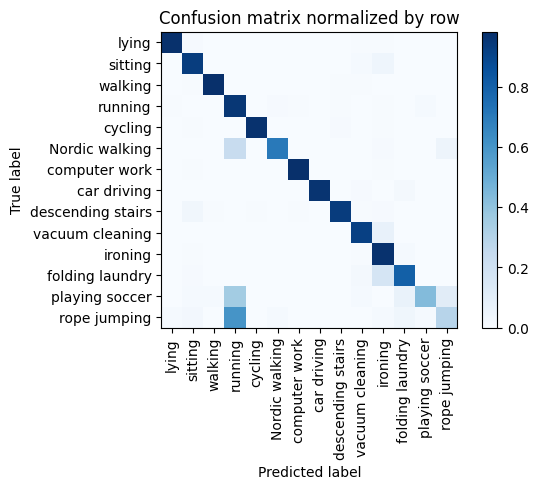

Overall accuracy: 0.912



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

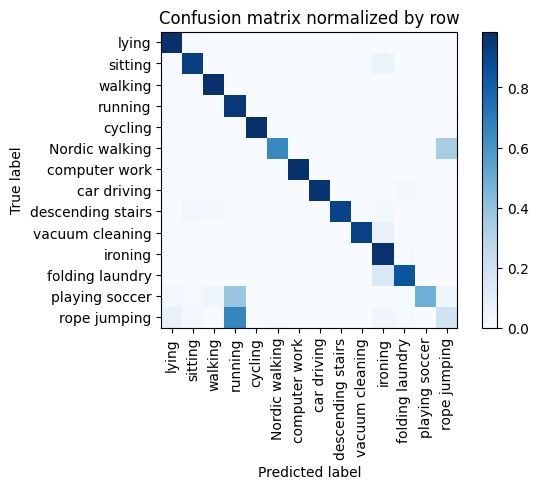

Overall accuracy: 0.907



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

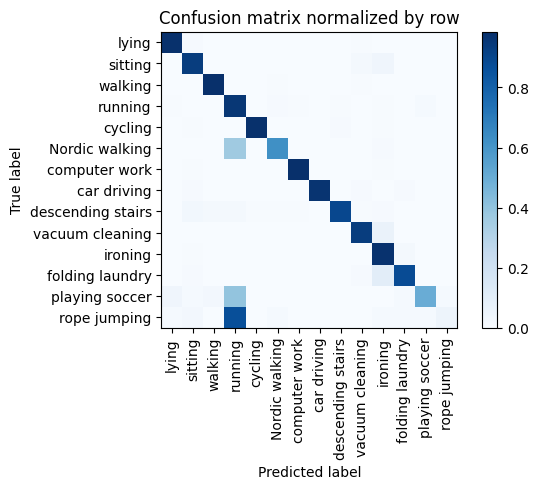

Overall accuracy: 0.905



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

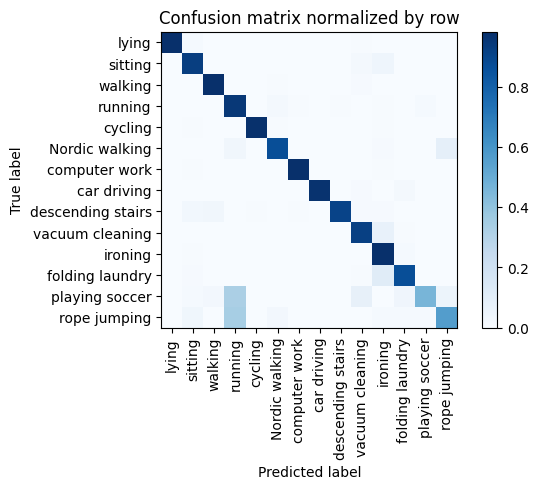

Overall accuracy: 0.934



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

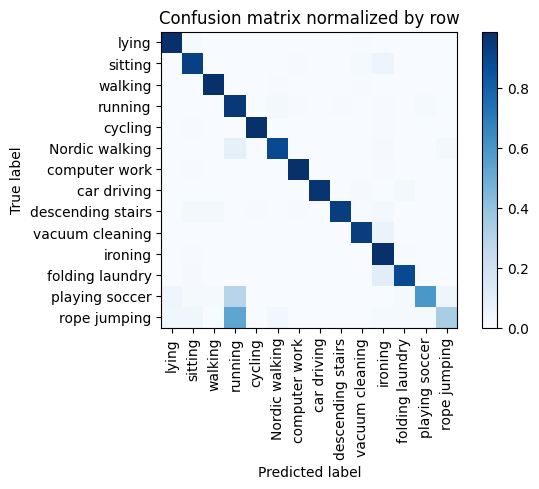

Overall accuracy: 0.937



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

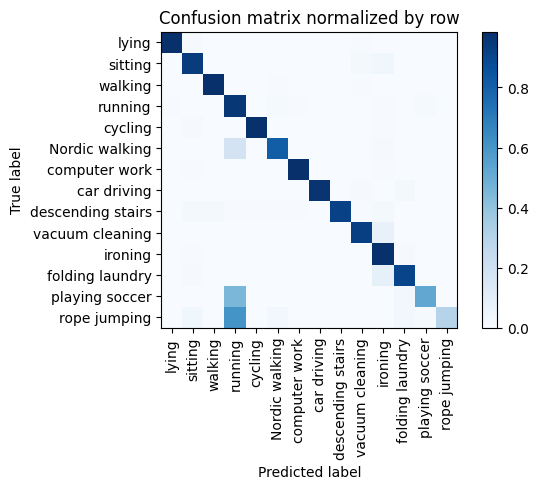

Overall accuracy: 0.930



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

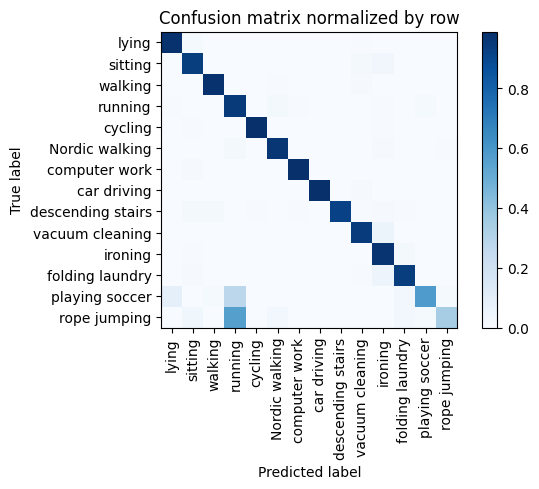

Overall accuracy: 0.947



train:   0%|          | 0/261 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

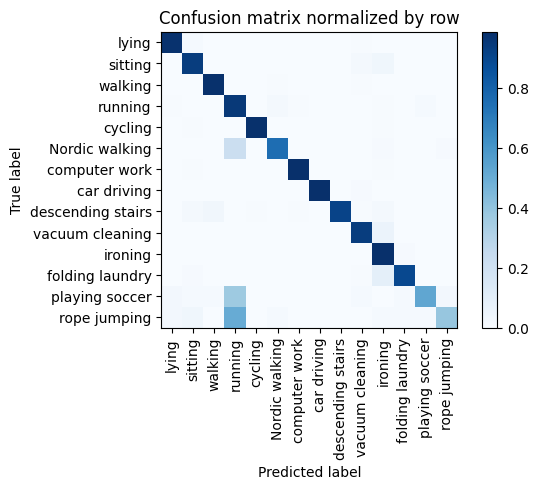

Overall accuracy: 0.928



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

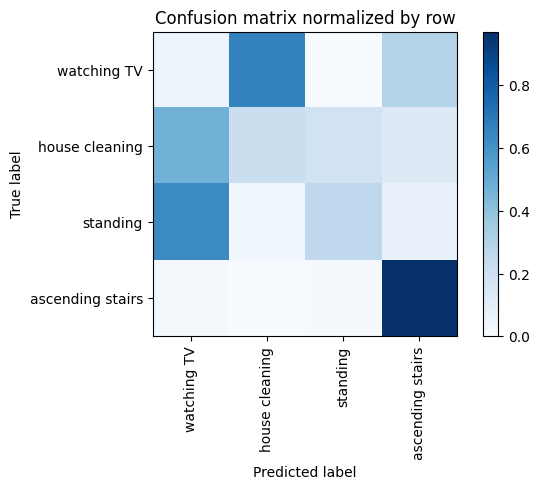

Overall accuracy: 0.351

{'accuracy': 0.35111350574712646, 'precision': 0.40450040926117525, 'recall': 0.37354936437211145, 'f1': 0.3570994871116026}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16]
unseen classes >  [3, 17, 1, 11]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

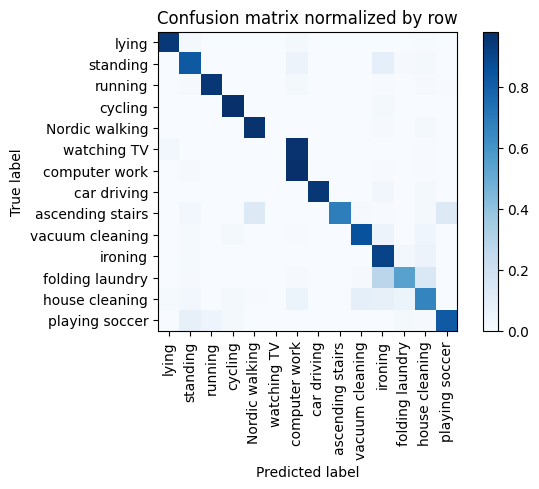

Overall accuracy: 0.841



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

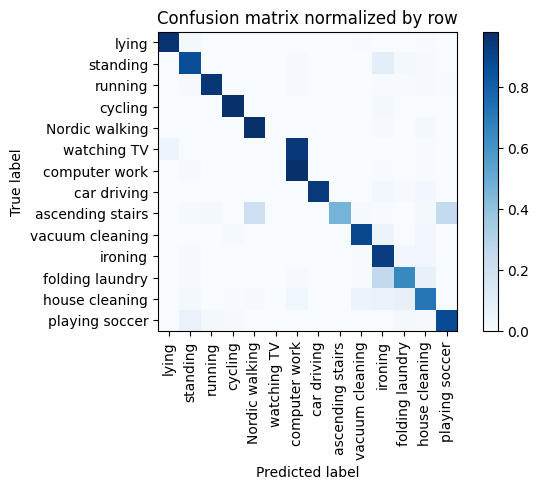

Overall accuracy: 0.850



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

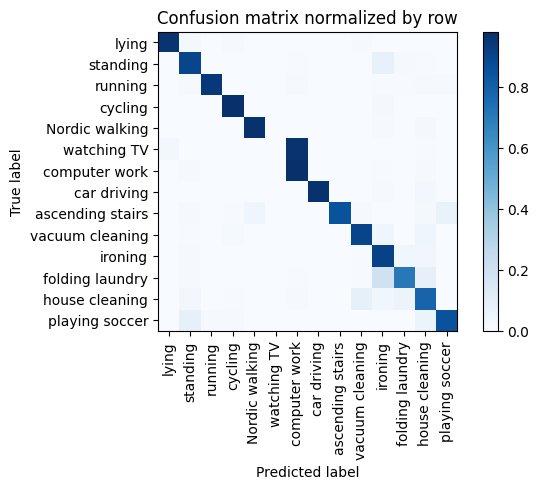

Overall accuracy: 0.879



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

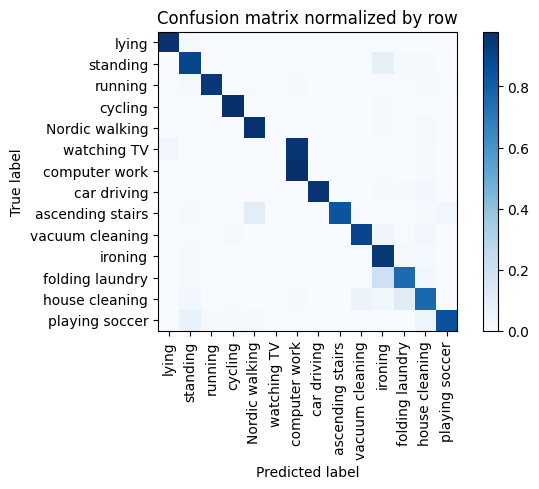

Overall accuracy: 0.882



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

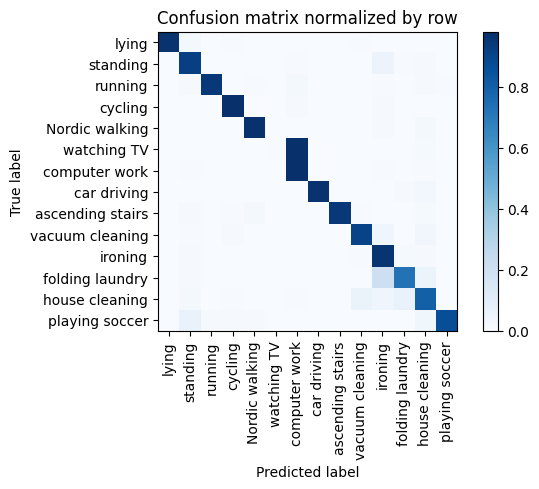

Overall accuracy: 0.896



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

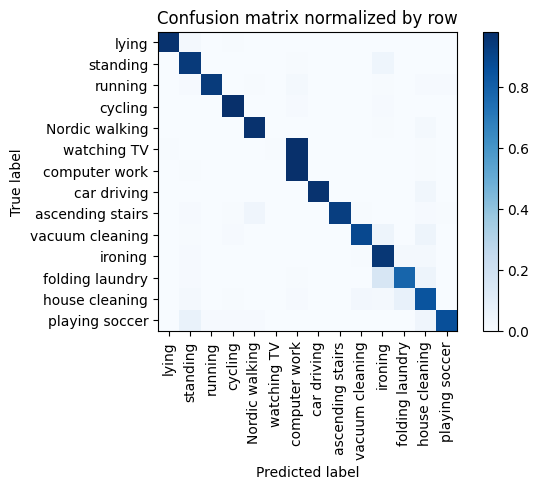

Overall accuracy: 0.901



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

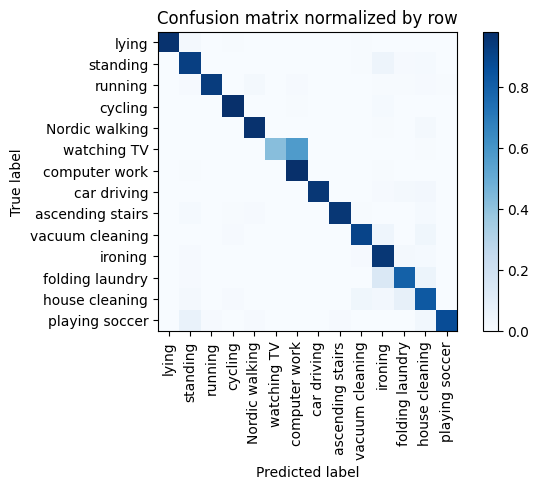

Overall accuracy: 0.915



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

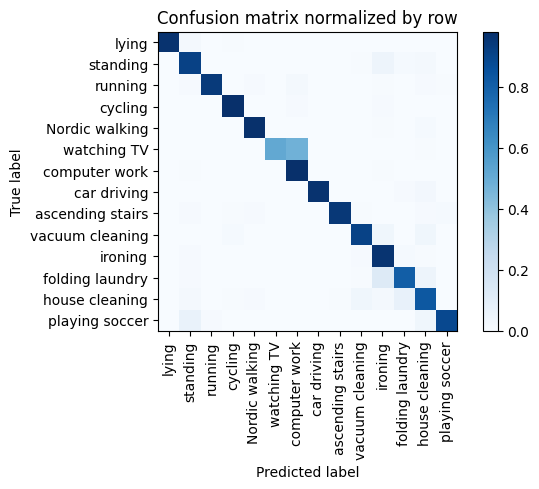

Overall accuracy: 0.922



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

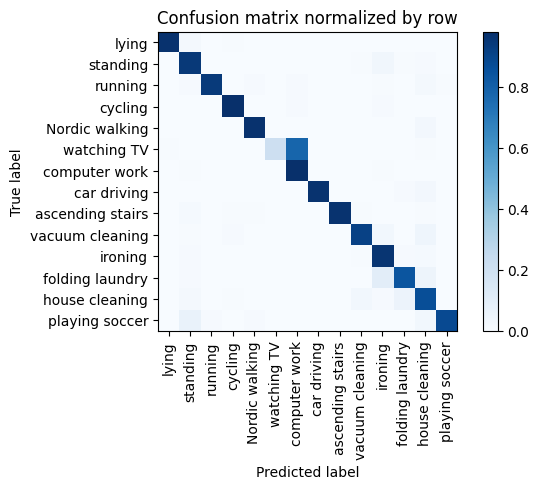

Overall accuracy: 0.919



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

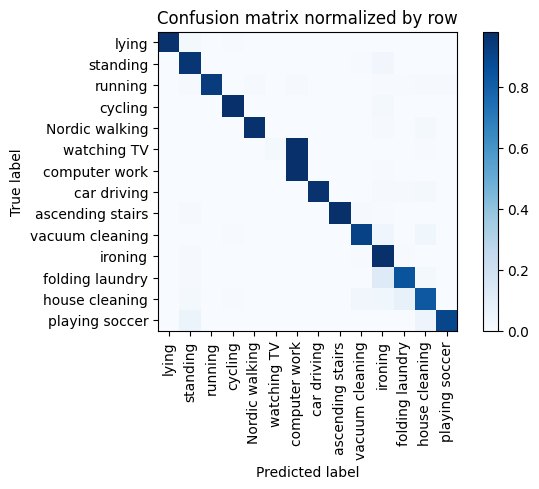

Overall accuracy: 0.911



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

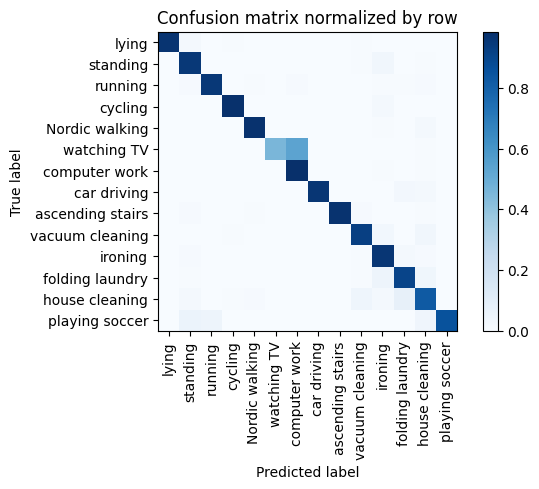

Overall accuracy: 0.928



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

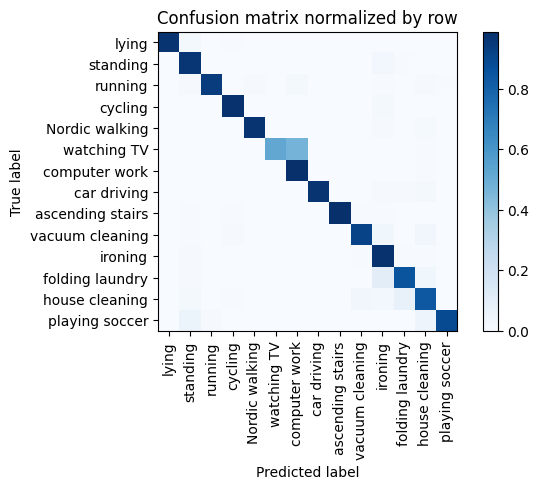

Overall accuracy: 0.932



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

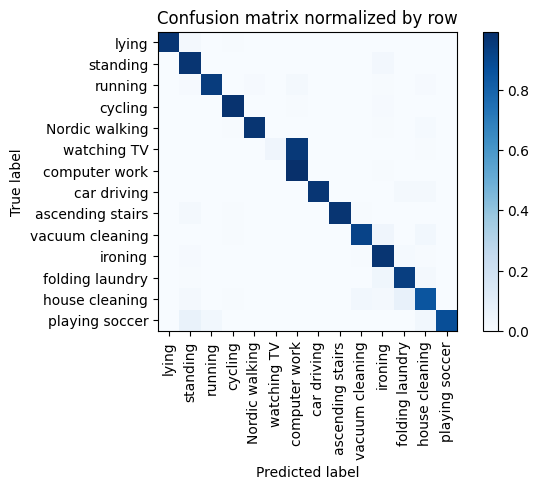

Overall accuracy: 0.920



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

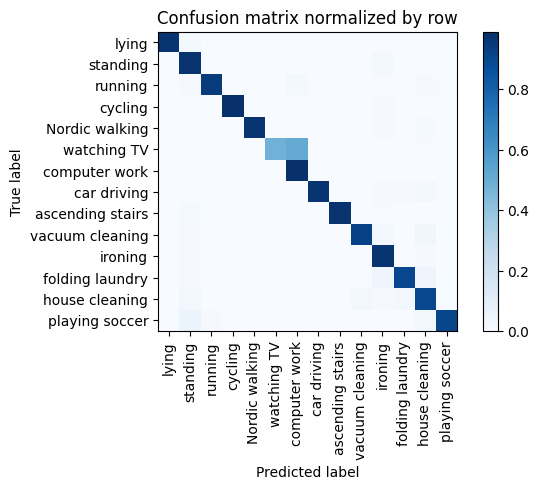

Overall accuracy: 0.942



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

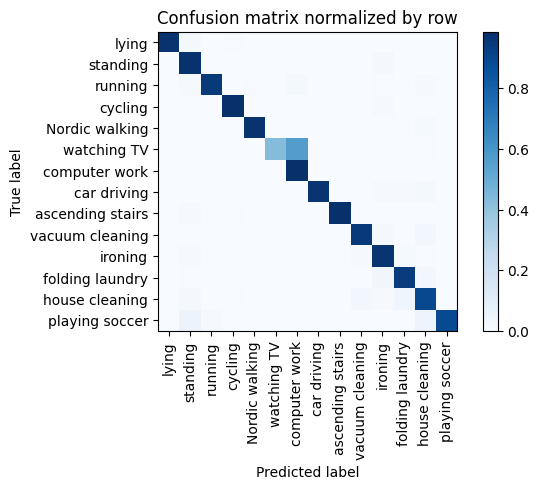

Overall accuracy: 0.941



unseen:   0%|          | 0/86 [00:00<?, ?batch/s]

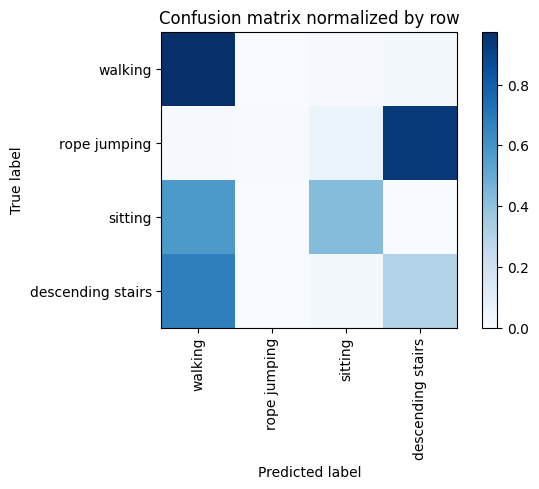

Overall accuracy: 0.601

{'accuracy': 0.6006540697674418, 'precision': 0.7197759603738839, 'recall': 0.42702675911194654, 'f1': 0.4131525846816677}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleaning', 'computer work']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17]
unseen classes >  [16, 0, 12, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

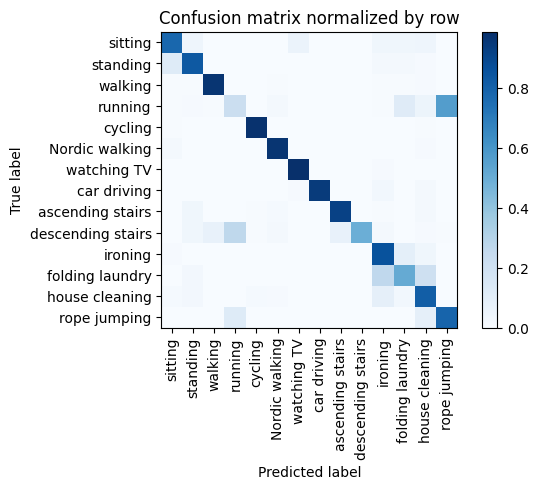

Overall accuracy: 0.823



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

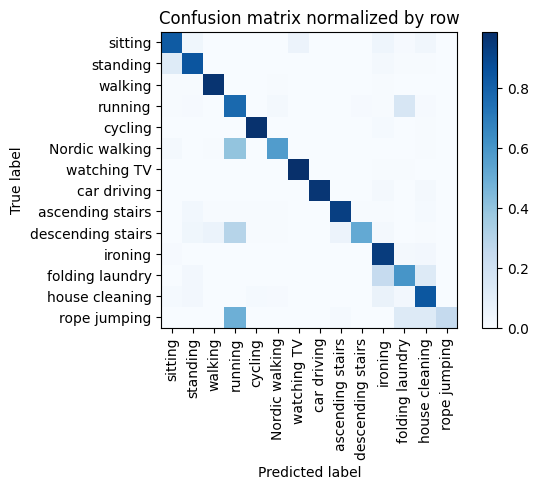

Overall accuracy: 0.826



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

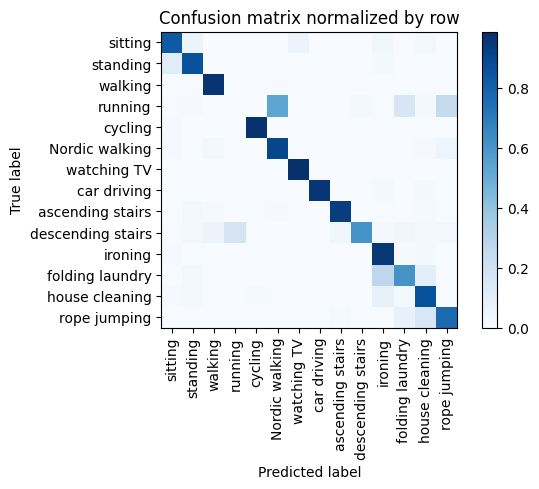

Overall accuracy: 0.842



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

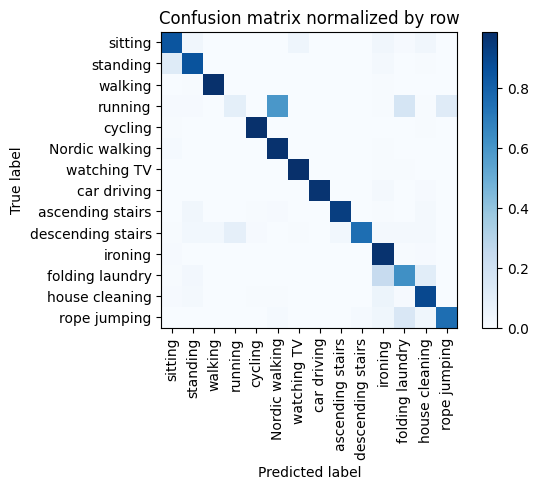

Overall accuracy: 0.868



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

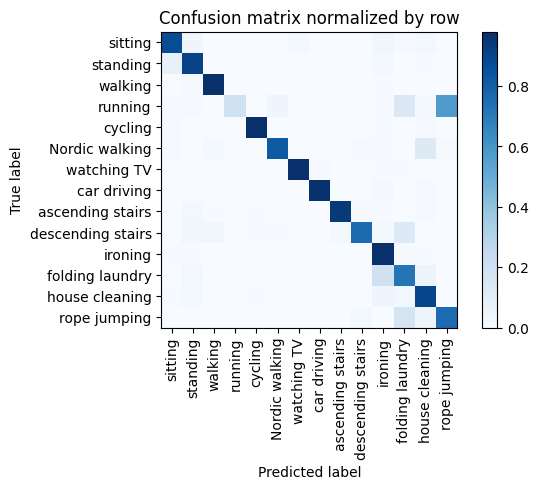

Overall accuracy: 0.870



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

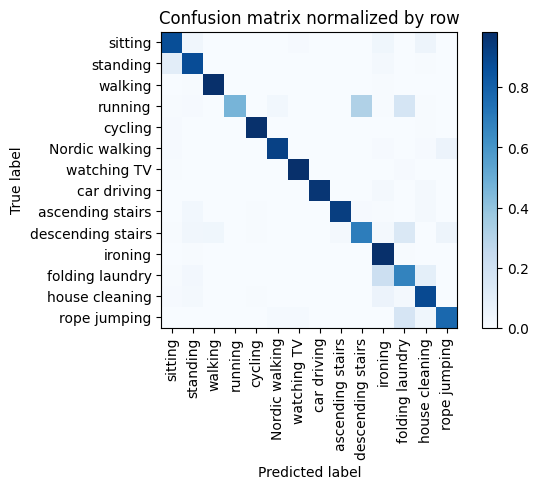

Overall accuracy: 0.885



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

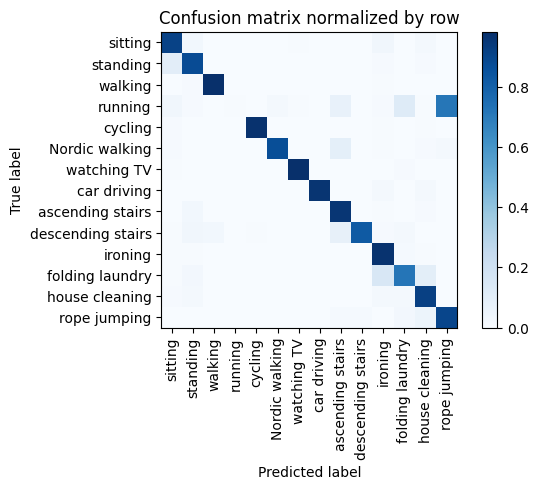

Overall accuracy: 0.877



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

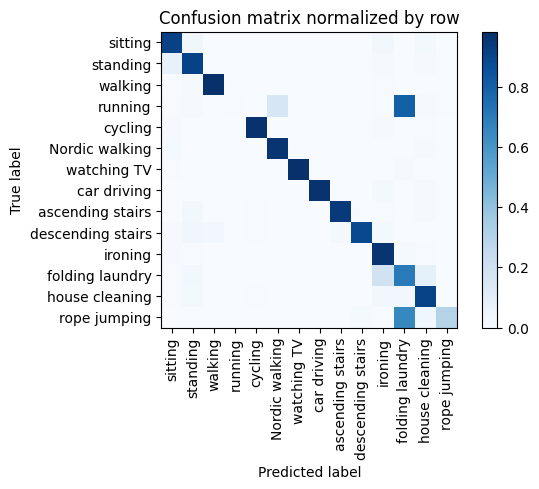

Overall accuracy: 0.877



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

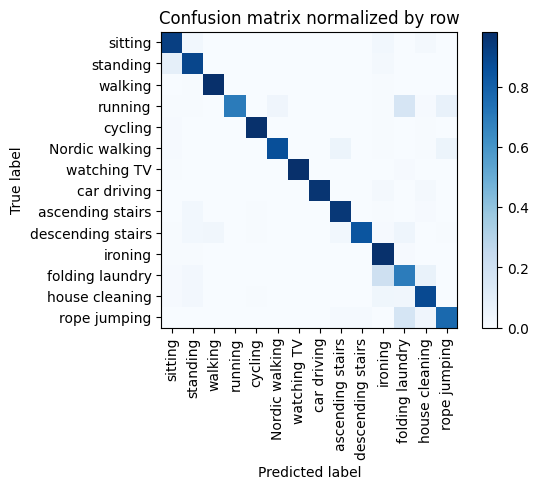

Overall accuracy: 0.907



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

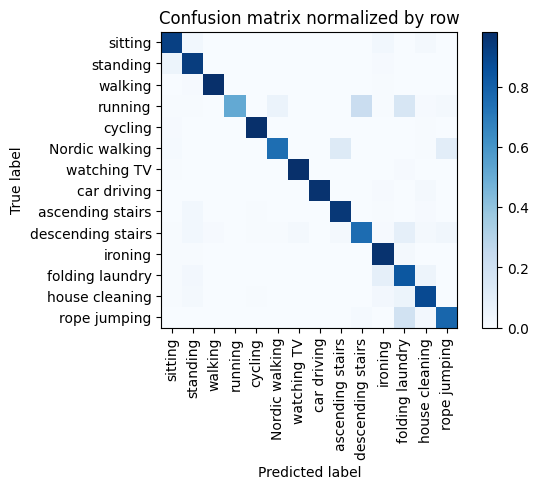

Overall accuracy: 0.893



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

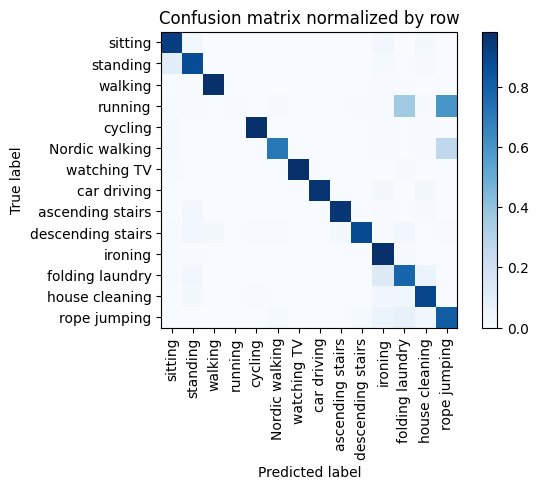

Overall accuracy: 0.866



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

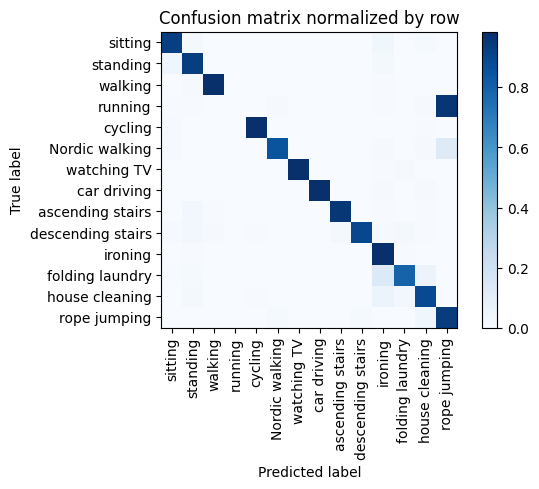

Overall accuracy: 0.890



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

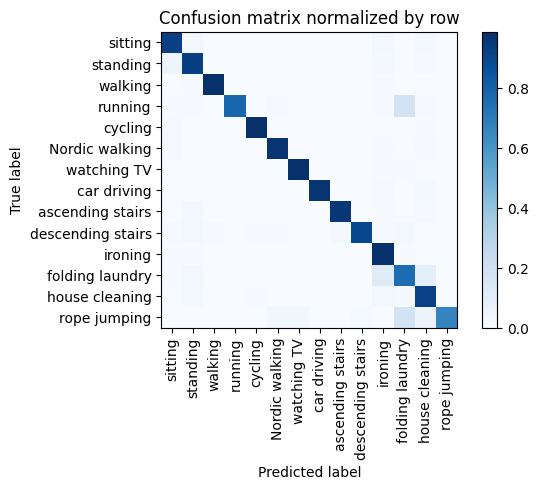

Overall accuracy: 0.932



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

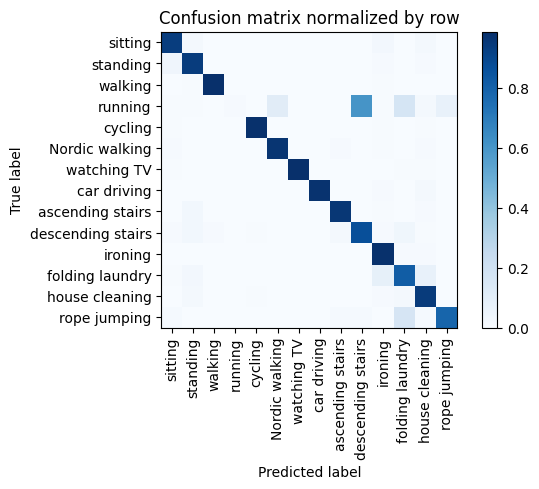

Overall accuracy: 0.903



train:   0%|          | 0/242 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

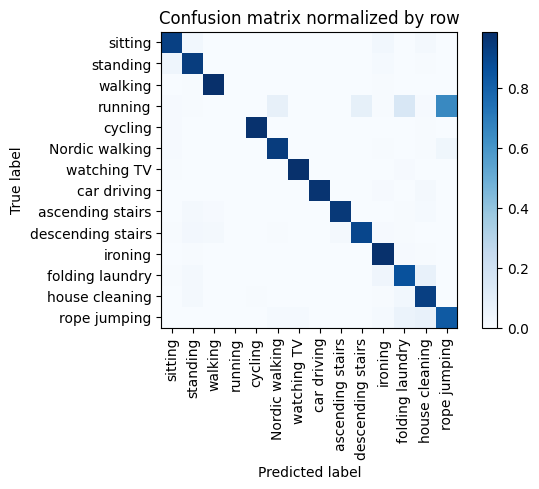

Overall accuracy: 0.903



unseen:   0%|          | 0/111 [00:00<?, ?batch/s]

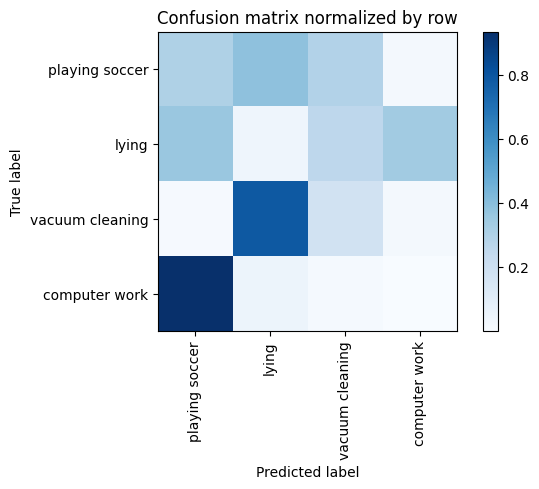

Overall accuracy: 0.075

{'accuracy': 0.07545045045045046, 'precision': 0.1028214556239504, 'recall': 0.1327951837494741, 'f1': 0.08678246945707298}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walking']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
unseen classes >  [5, 4, 6]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

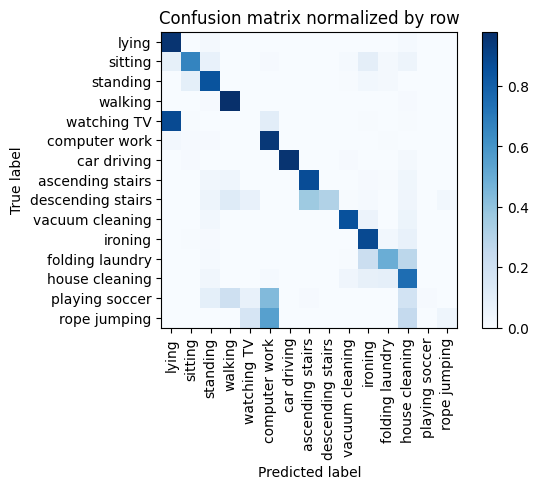

Overall accuracy: 0.760



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

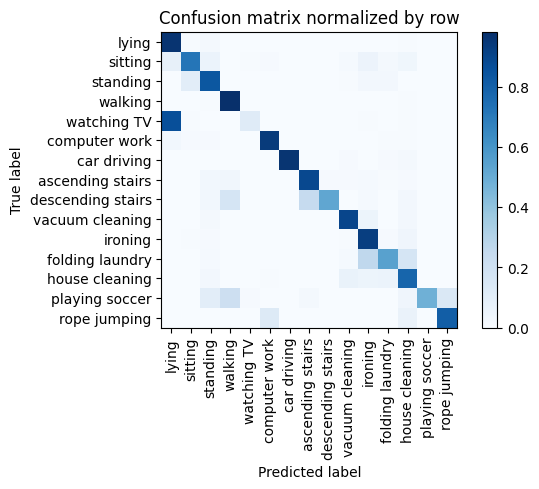

Overall accuracy: 0.820



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

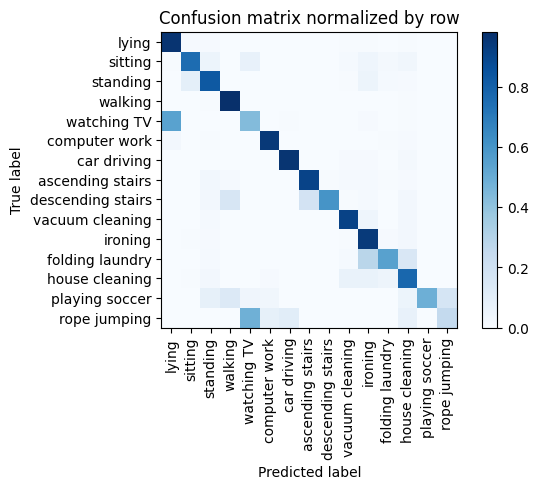

Overall accuracy: 0.831



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

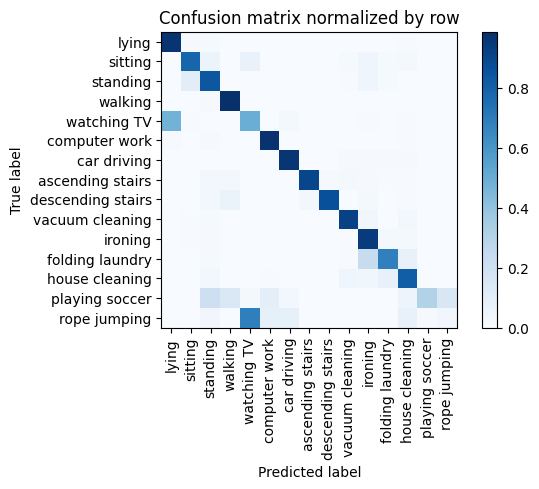

Overall accuracy: 0.849



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

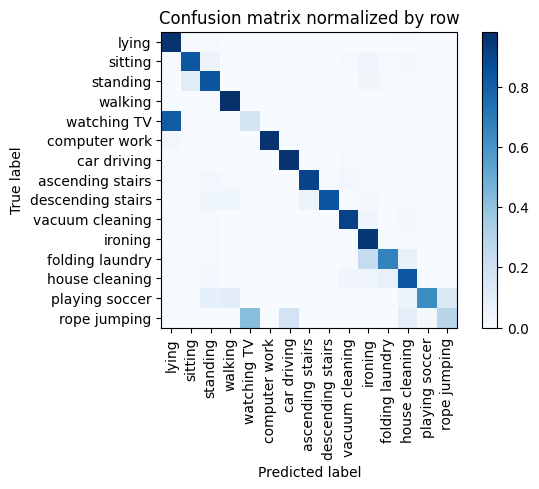

Overall accuracy: 0.854



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

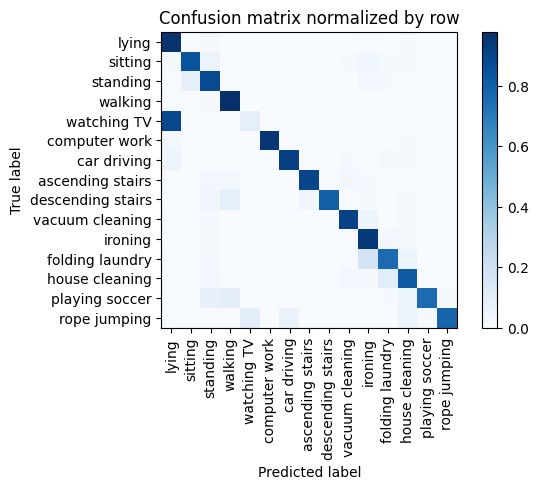

Overall accuracy: 0.865



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

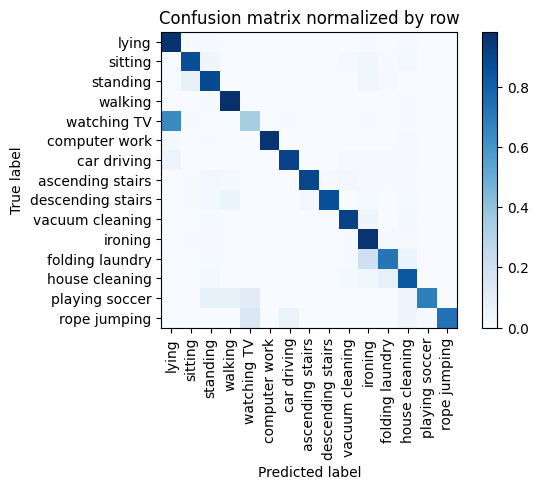

Overall accuracy: 0.880



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

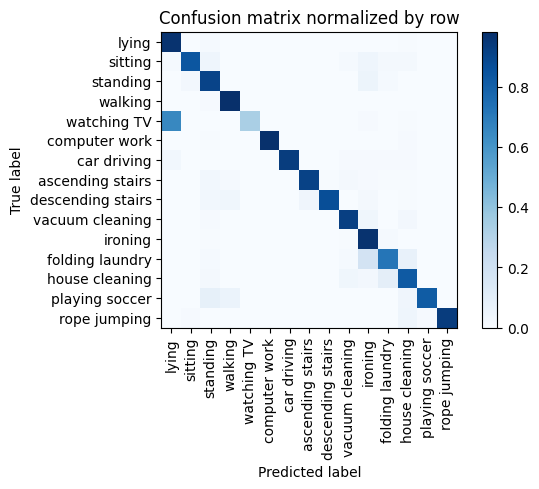

Overall accuracy: 0.894



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

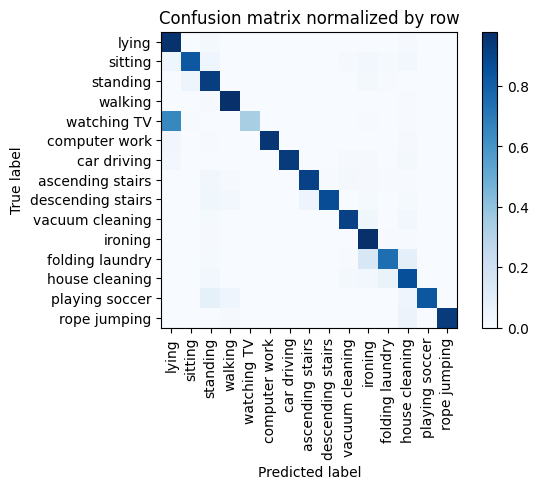

Overall accuracy: 0.894



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

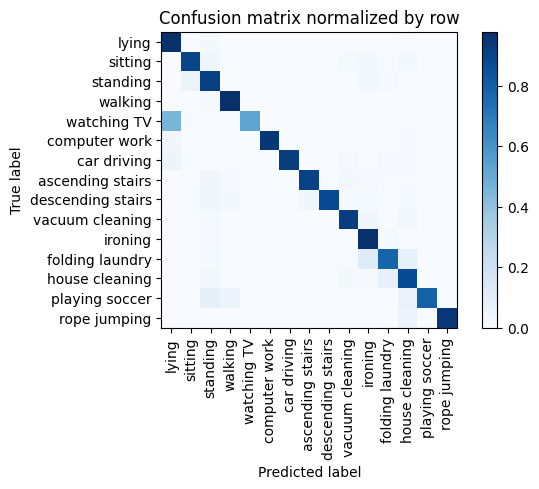

Overall accuracy: 0.908



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

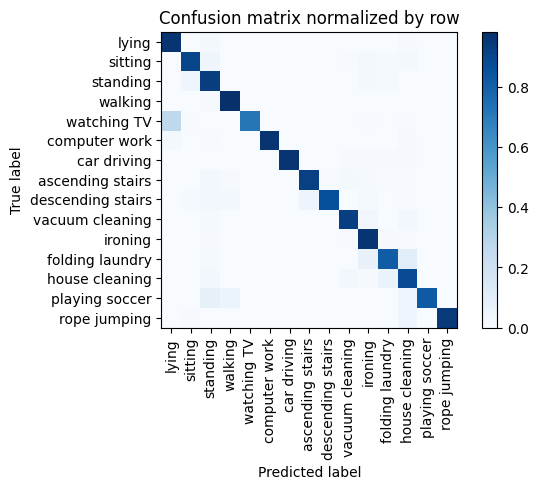

Overall accuracy: 0.922



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

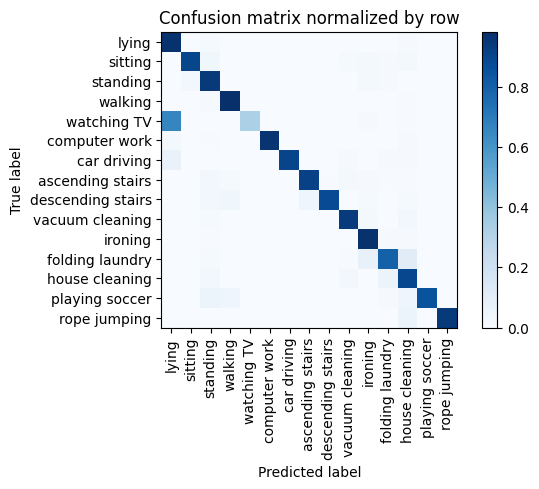

Overall accuracy: 0.909



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

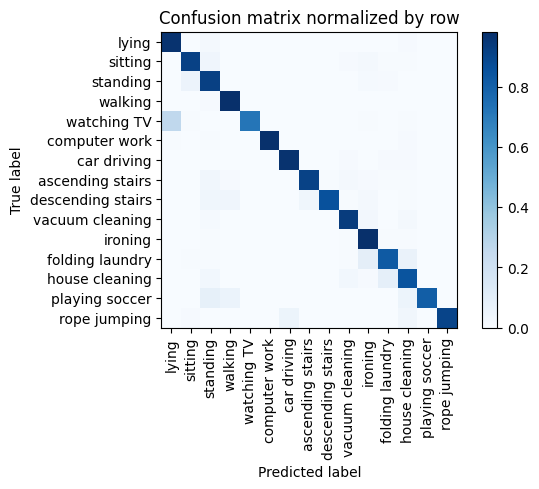

Overall accuracy: 0.924



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

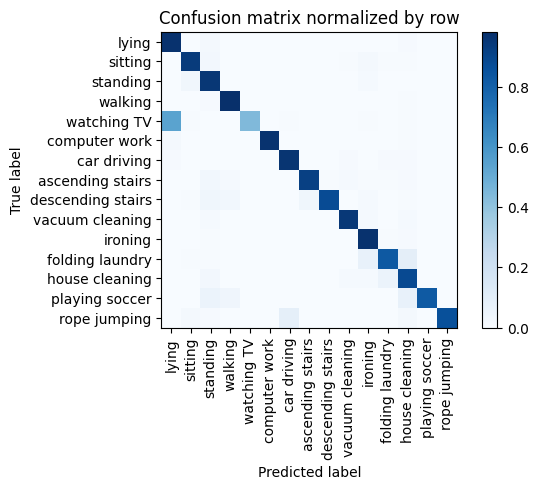

Overall accuracy: 0.920



train:   0%|          | 0/276 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

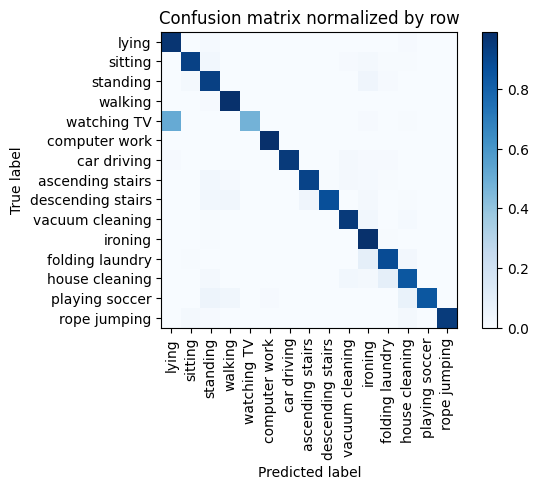

Overall accuracy: 0.923



unseen:   0%|          | 0/68 [00:00<?, ?batch/s]

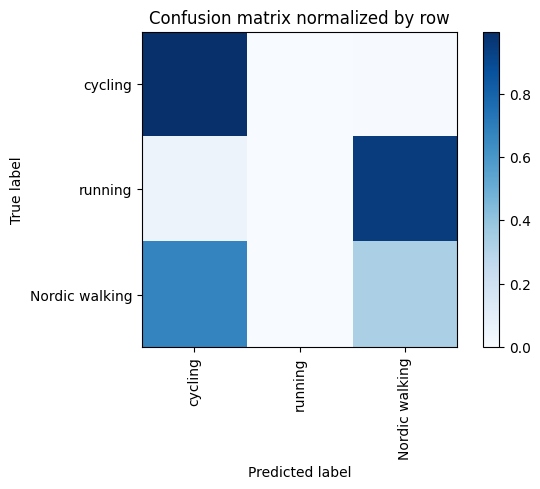

Overall accuracy: 0.502

{'accuracy': 0.5018382352941176, 'precision': 0.31899329904940005, 'recall': 0.44209478114094686, 'f1': 0.3584072840402073}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
per class count :  {'lying': 8, 'sitting': 8, 'standing': 8, 'walking': 8, 'running': 6, 'cycling': 7, 'Nordic walking': 7, 'watching TV': 1, 'computer work': 4, 'car driving': 1, 'ascending stairs': 16, 'descending stairs': 17, 'vacuum cleaning': 8, 'ironing': 8, 'folding laundry': 4, 'house cleaning': 5, 'playing soccer': 2, 'rope jumping': 6}
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
unseen classes >  [13, 9, 14]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

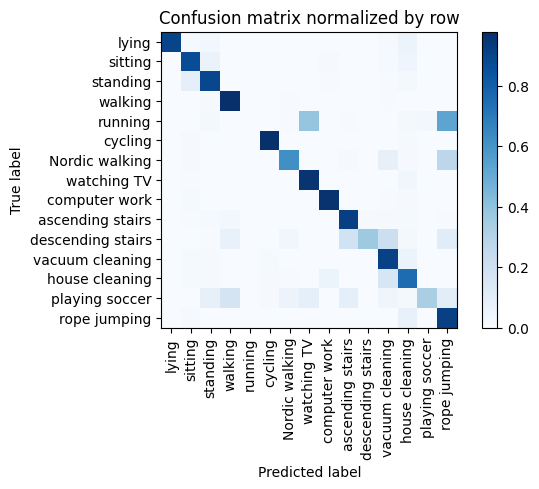

Overall accuracy: 0.816



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

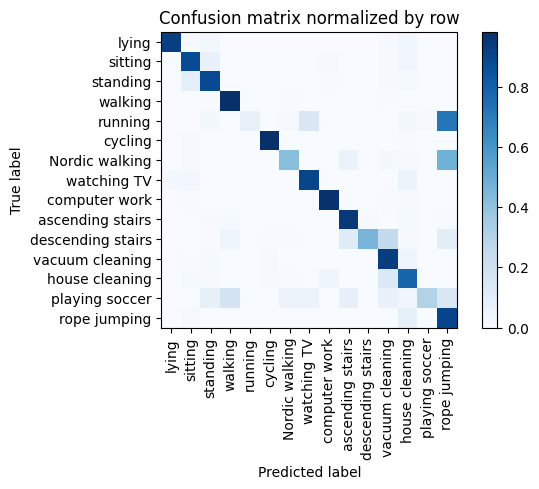

Overall accuracy: 0.810



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

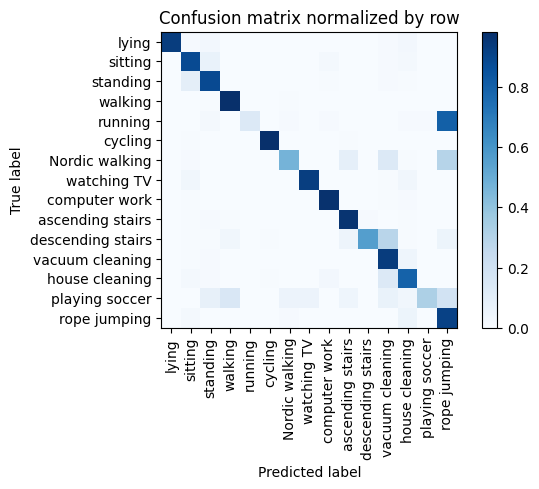

Overall accuracy: 0.829



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

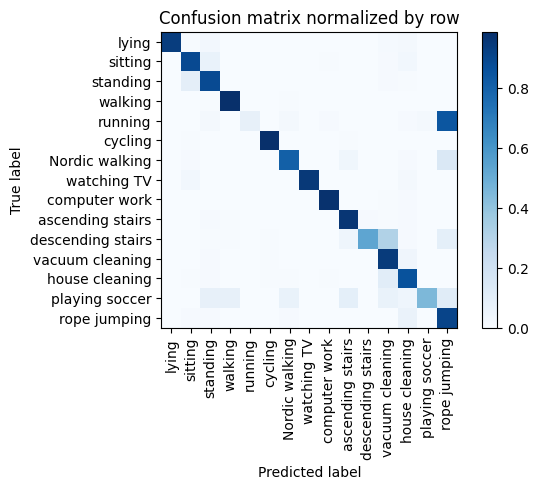

Overall accuracy: 0.865



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

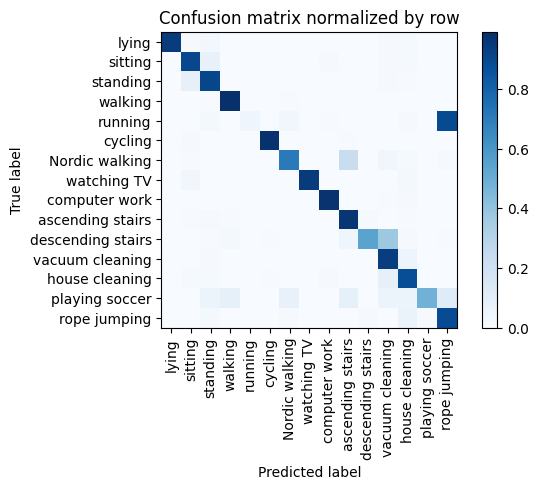

Overall accuracy: 0.860



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

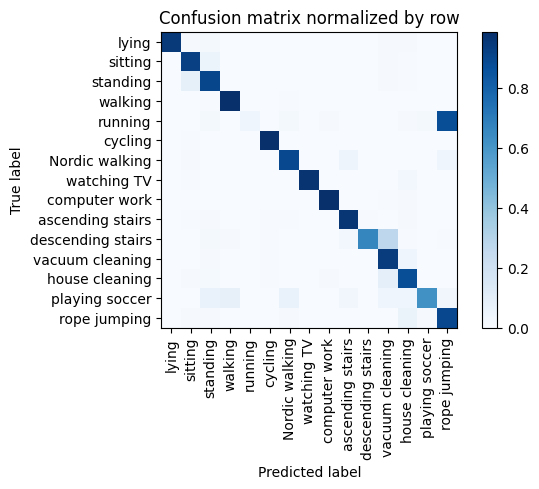

Overall accuracy: 0.887



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

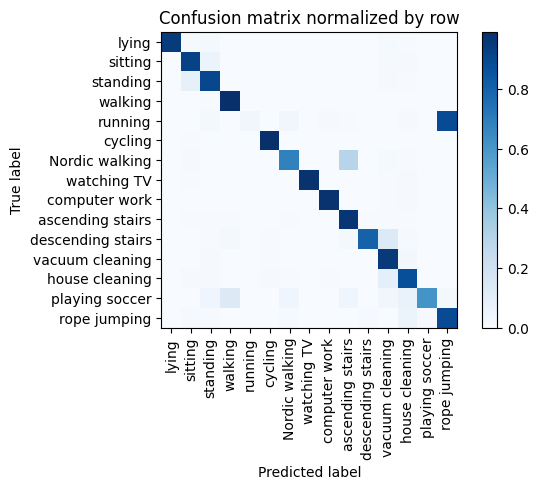

Overall accuracy: 0.875



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

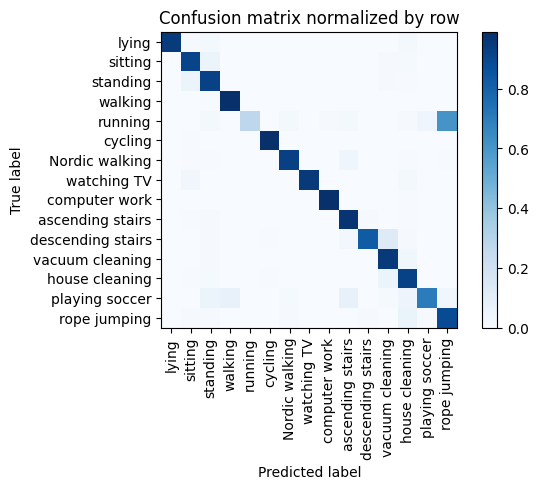

Overall accuracy: 0.914



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

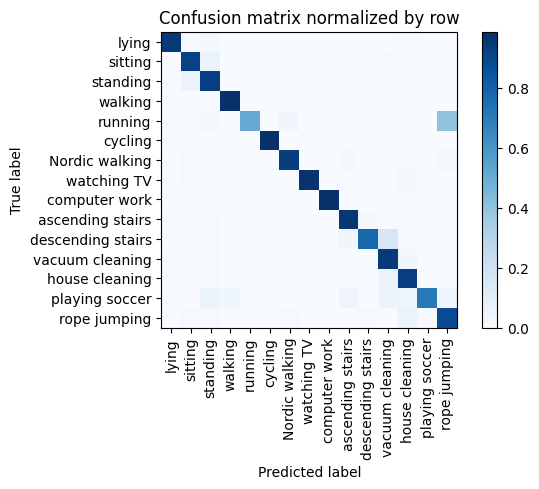

Overall accuracy: 0.924



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

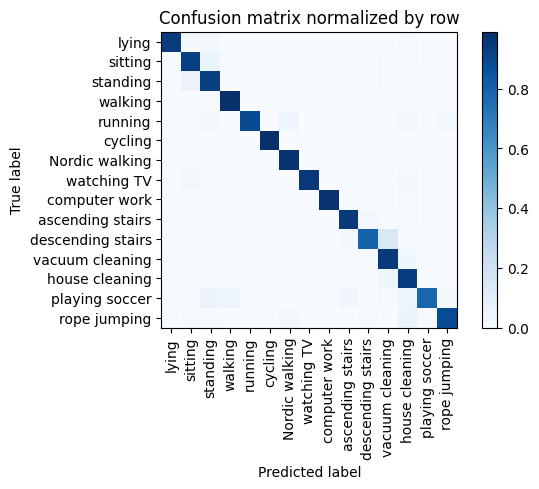

Overall accuracy: 0.945



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

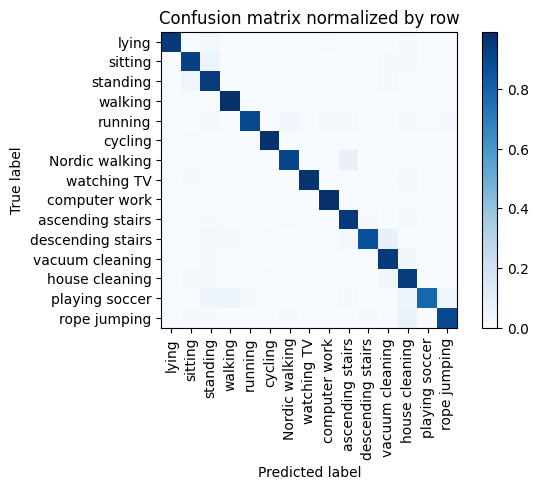

Overall accuracy: 0.947



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

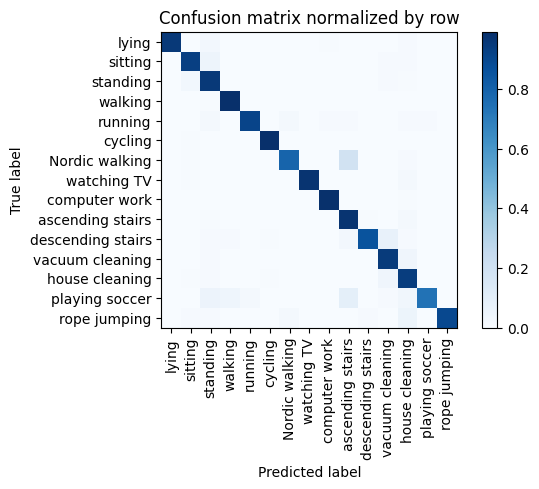

Overall accuracy: 0.938



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

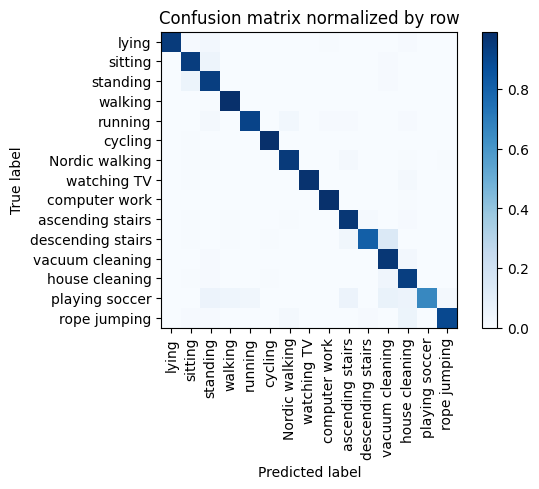

Overall accuracy: 0.949



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

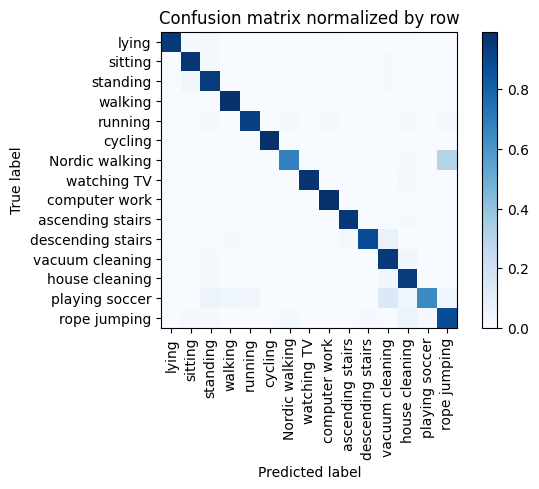

Overall accuracy: 0.931



train:   0%|          | 0/283 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

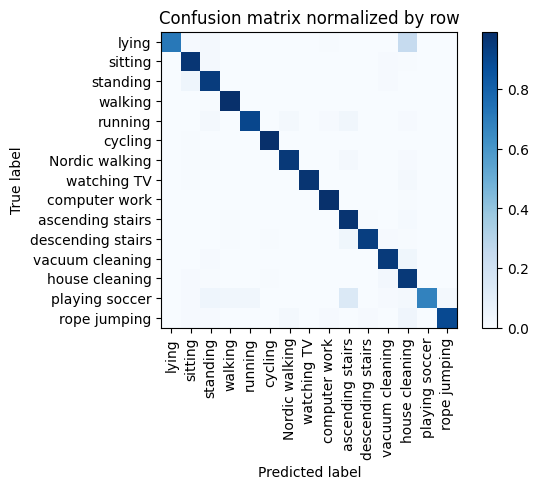

Overall accuracy: 0.939



unseen:   0%|          | 0/60 [00:00<?, ?batch/s]

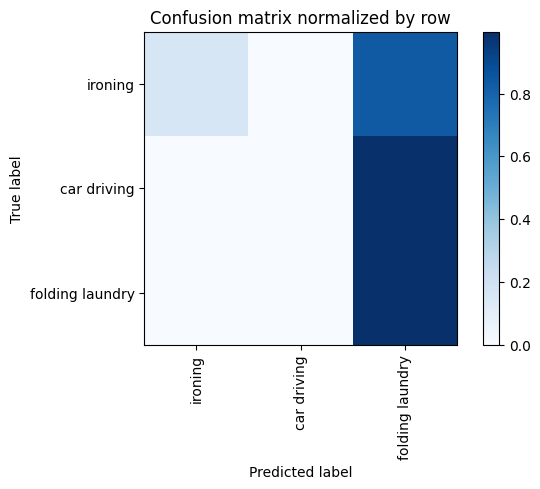

Overall accuracy: 0.352

{'accuracy': 0.35182291666666665, 'precision': 0.42262681599667173, 'recall': 0.3868120218723856, 'f1': 0.23959322003074143}
============== Overall Unseen Classes Performance ==============


accuracy     0.376176
precision    0.393744
recall       0.352456
f1           0.291007
dtype: float64

In [37]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'],weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=False, loss_alpha=0.0001)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],   phase='unseen', loss_alpha=0.0001, print_report=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
